# Poisson Regression in PyTorch

Poisson regression uses a likelihood based on the Poisson distribution.

The model that we'll fit is:

\begin{align*}
y_{i} &\sim \textrm{Poisson}(\lambda_{i}) ~~~ \textrm{for}~ i=1, ..., N, \\
\textrm{Log}(\lambda_{i}) &= \boldsymbol{x}_{i}^{\top} \boldsymbol{\beta}, 
\end{align*}

where 

* $y_{i}$ is the response of the $i\textrm{th}$ observation.
* $\boldsymbol{x}_{i}$ is the vector of covariate values for the $i\textrm{th}$ observation.
* $\boldsymbol{\beta}$ is the vector of effects for the fixed covariates.

The probability density function of the Poisson distribution is:

\begin{align*}
f(y_{i}; \lambda_{i}) &= \frac{\lambda_{i}^{y_{i}} \textrm{exp}(-\lambda_{i})}{y_{i}!}
\end{align*}

Thus, the likelihood is 

\begin{align*}
L(\lambda_{i}; y_{i}) &= \prod_{i=1}^{N} \lambda_{i}^{y_{i}} (y_{i}!)^{-1} \textrm{exp}(-\lambda_{i})
\end{align*}

The log-likelihood is 

\begin{align*}
\textrm{log}(L(\lambda_{i}; y_{i})) &= \sum_{i=1}^{N}\textrm{log} \left[ \lambda_{i}^{y_{i}} (y_{i}!)^{-1} \textrm{exp}(-\lambda_{i}) \right] \\
&= \sum_{i=1}^{N} \left[ y_{i}\textrm{log}(\lambda_{i}) - \textrm{log}(y_{i}!) -\lambda_{i} \right]
\end{align*}

The negative log-likelihood is 

\begin{align*}
-\textrm{log}(L(\lambda_{i}; y_{i})) &= -\sum_{i=1}^{N} \left[ y_{i}\textrm{log}(\lambda_{i}) - \textrm{log}(y_{i}!) -\lambda_{i} \right] \\
&= -\sum_{i=1}^{N} \left[ y_{i} \boldsymbol{x}_{i}^{\top} \boldsymbol{\beta} - \textrm{log}(y_{i}!) - \textrm{exp}(\boldsymbol{x}_{i}^{\top} \boldsymbol{\beta}) \right]
\end{align*}

## Import libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from library.PoissonRegression import PoissonRegression

## Step 1: Generate synthetic data for the Poisson regression

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

n = 1000  # sample size
p = 1      # number of predictors (excluding intercept); change as needed

if p == 1:
    X = torch.linspace(0, 1, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    X = torch.rand(n, p)

# True parameters: fixed effects vector β (including an intercept)
beta_true = torch.randn(p + 1, 1)  + 2

# Create design matrix with intercept
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)

# Compute the linear predictor η and the rate λ using the log link: λ = exp(η)
eta = X_with_intercept @ beta_true
lambda_true = torch.exp(eta)

# Generate observed count responses: y ~ Poisson(λ)
y = torch.poisson(lambda_true)

## Step 2: Plot the data

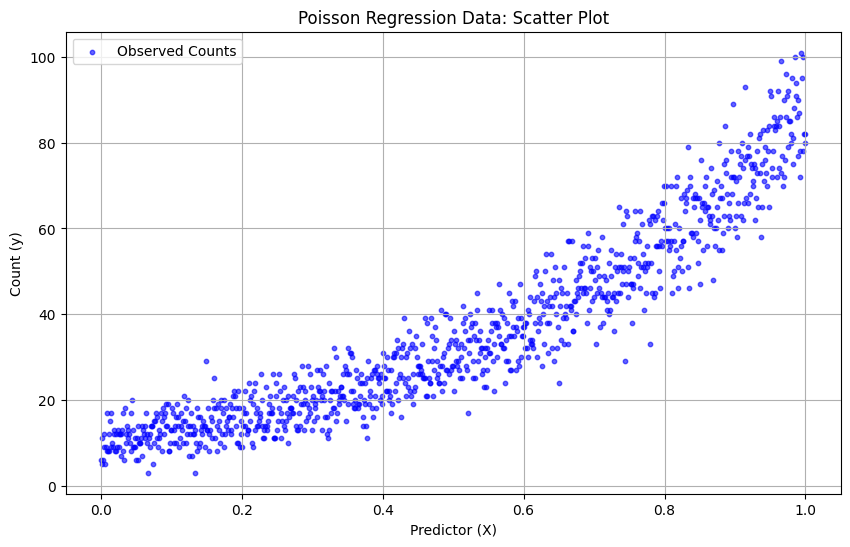

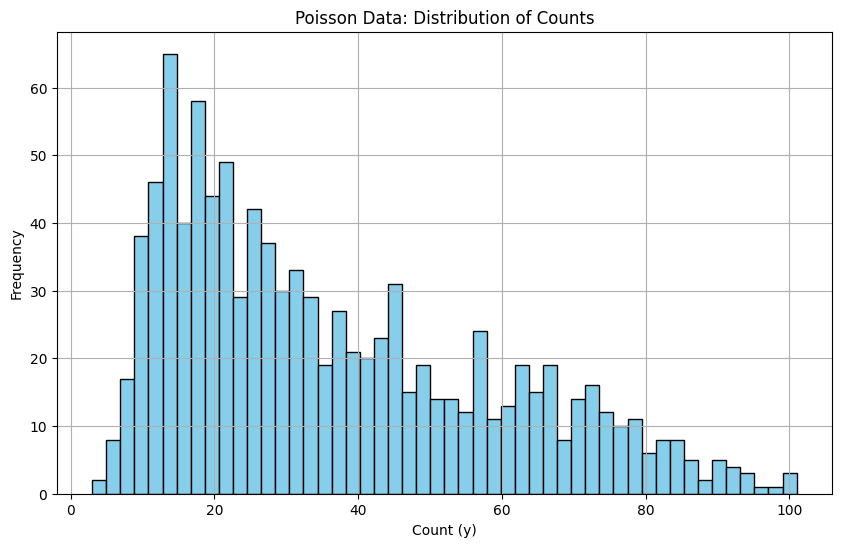

In [3]:
# Scatter Plot of Poisson Data
plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), s=10, alpha=0.6, color='blue', label='Observed Counts')
plt.xlabel('Predictor (X)')
plt.ylabel('Count (y)')
plt.title('Poisson Regression Data: Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Count Data
plt.figure(figsize=(10, 6))
plt.hist(y.numpy(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Count (y)')
plt.ylabel('Frequency')
plt.title('Poisson Data: Distribution of Counts')
plt.grid(True)
plt.show()

# Step 3: Instantiate model and optimizer

In [4]:
model = PoissonRegression(X)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the model

In [5]:
num_epochs = 3000
losses = []
import time
start_time = time.time()  # Start timer

for epoch in range(num_epochs):
    loss = model.negative_log_likelihood(X, y)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop timer
print(f"Training completed in {elapsed_time:.2f} seconds")


Epoch [1000/3000], NLL: -99490.4141
Epoch [2000/3000], NLL: -99617.8359
Epoch [3000/3000], NLL: -99617.9688
Training completed in 1.10 seconds


# Step 5: Extract learned parameters

In [6]:
learned_beta_poisson = model.beta.data.flatten()
print("Learned β:", learned_beta_poisson.tolist())
print("True β:   ", beta_true.flatten().tolist())

Learned β: [2.339421272277832, 2.1299338340759277]
True β:    [2.3366904258728027, 2.1288094520568848]


# Step 6: Plot results

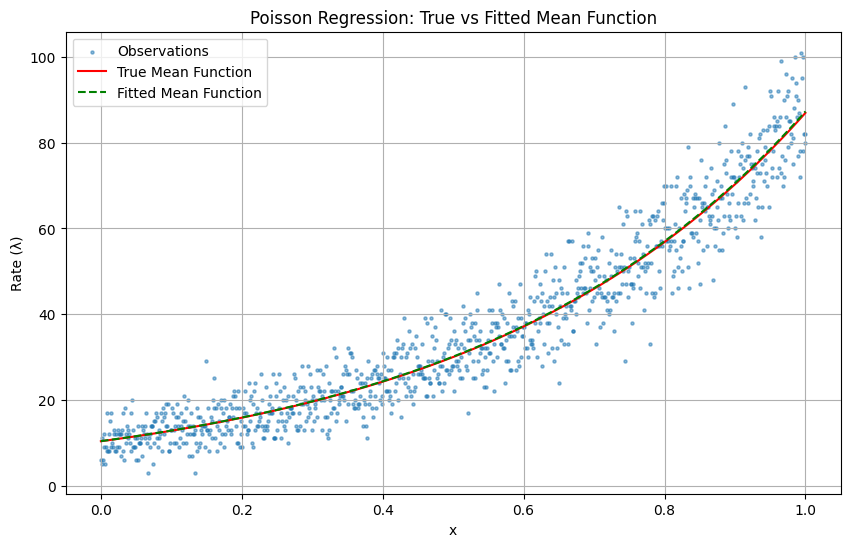

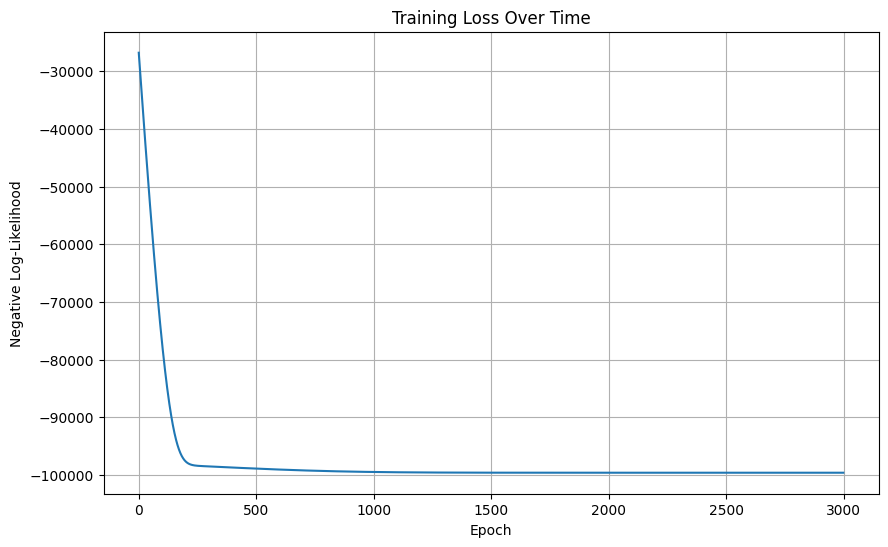

In [7]:
plt.figure(figsize=(10, 6))
    
# Scatter plot of observed counts
plt.scatter(X.numpy(), y.numpy(), label='Observations', s=5, alpha=0.5)

# Create a dense grid for plotting the mean function
x_range = torch.linspace(0, 1, 100).reshape(-1, 1)
ones_range = torch.ones(x_range.size(0), 1)
X_range_with_intercept = torch.cat([ones_range, x_range], dim=1)

# Compute the true mean function: λ = exp(X*β_true)
true_lambda_range = torch.exp(X_range_with_intercept @ beta_true).detach().numpy()

# Compute the fitted mean function using the learned β
fitted_lambda_range = model(x_range).detach().numpy()

plt.plot(x_range.numpy(), true_lambda_range, 'r', label='True Mean Function')
plt.plot(x_range.numpy(), fitted_lambda_range, 'g--', label='Fitted Mean Function')

plt.xlabel('x')
plt.ylabel('Rate (λ)')
plt.title('Poisson Regression: True vs Fitted Mean Function')
plt.legend()
plt.grid(True)
plt.show()

# Plot the loss curve
plt.figure(figsize=(10,6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()